In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import random
import visualkeras
from keras import callbacks
from sklearn.metrics import accuracy_score
import seaborn as sns# Preparing folders
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg16 import VGG16

# Preparing folders

In [2]:
classes = {0:'Bread',
           1:'Dairy product',
           2: 'Dessert',
           3: 'Egg',
           4: 'Fried food',
           5: 'Meat',
           6: 'Noodles/Pasta',
           7: 'Rice',
           8: 'Seafood',
           9: 'Soup',
           10: 'Vegetable/Fruit'}

num_categories = len(classes)

In [3]:
#function for creating folders to differentiate between food and non food

def create_dir(directory_name):

    try:
        # Create target Directory
        os.mkdir(directory_name)
        print("Directory " , directory_name ,  " Created ") 
        
    except FileExistsError:
        print("Directory " , directory_name ,  " already exists")

In [4]:
training_dir = '/Users/mac/Downloads/archive/training'
validation_dir = '/Users/mac/Downloads/archive/validation'
test_dir = '/Users/mac/Downloads/archive/evaluation'

In [5]:
df_paths_training = pd.DataFrame()
df_paths_validation = pd.DataFrame()
df_paths_evaluation = pd.DataFrame()

for img in os.listdir(training_dir):
    
    df_temp = pd.DataFrame({'path':[img],
                            'class':[img[0:img.find('_')]]})

    df_paths_training=df_paths_training.append(df_temp)
    
for img in os.listdir(validation_dir):
    
    df_temp = pd.DataFrame({'path':[img],
                            'class':[img[0:img.find('_')]]})

    df_paths_validation=df_paths_validation.append(df_temp)
    
for img in os.listdir(test_dir):
    
    df_temp = pd.DataFrame({'path':[img],
                            'class':[img[0:img.find('_')]]})

    df_paths_evaluation=df_paths_evaluation.append(df_temp)

## Question 1

In [ ]:
print('Training')
print(df_paths_training['class'].count())
print('---')

print('Validation')
print(df_paths_validation['class'].count())
print('---')

print('Evaluation')
print(df_paths_evaluation['class'].count())

## Question 2 et 3

Text(0.5, 1.0, 'Evaluation')

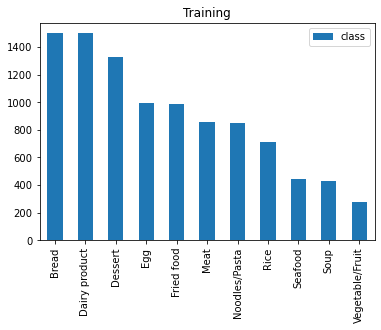

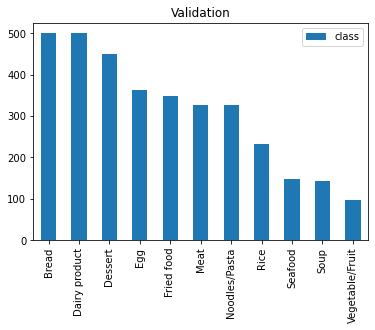

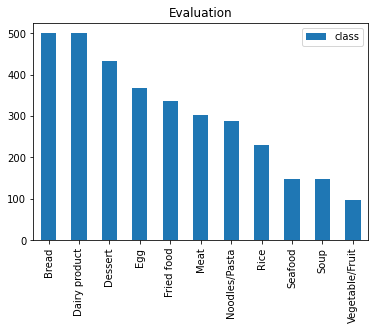

In [6]:
training_vc = df_paths_training['class'].value_counts()
validation_vc = df_paths_validation['class'].value_counts()
evaluation_vc = df_paths_evaluation['class'].value_counts()


training_vc.reset_index().rename(classes).plot.bar()
plt.title('Training')

validation_vc.reset_index().rename(classes).plot.bar()
plt.title('Validation')

evaluation_vc.reset_index().rename(classes).plot.bar()
plt.title('Evaluation')

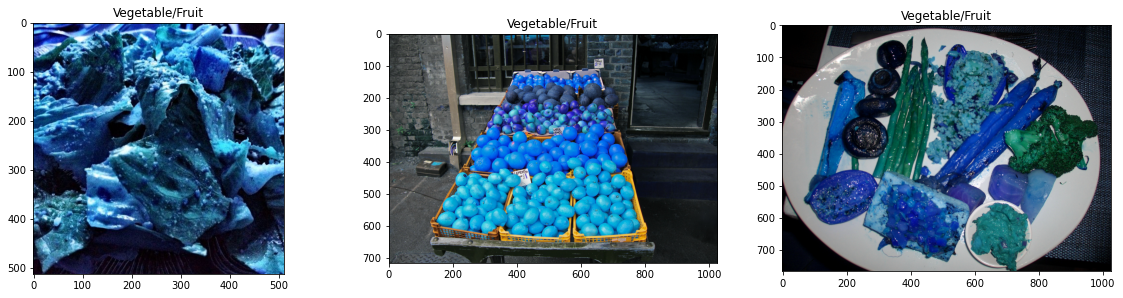

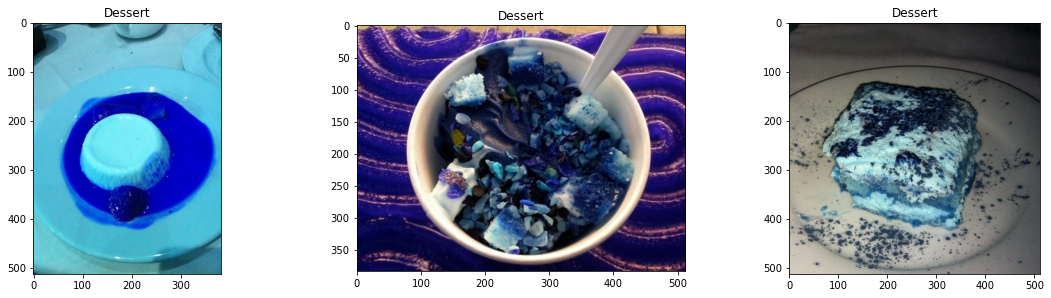

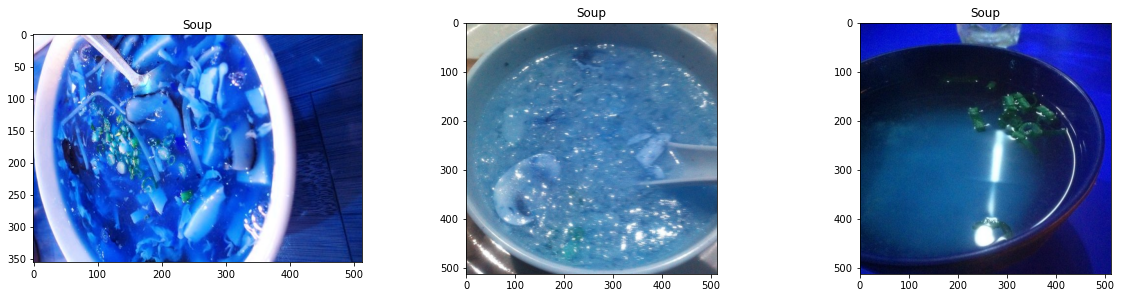

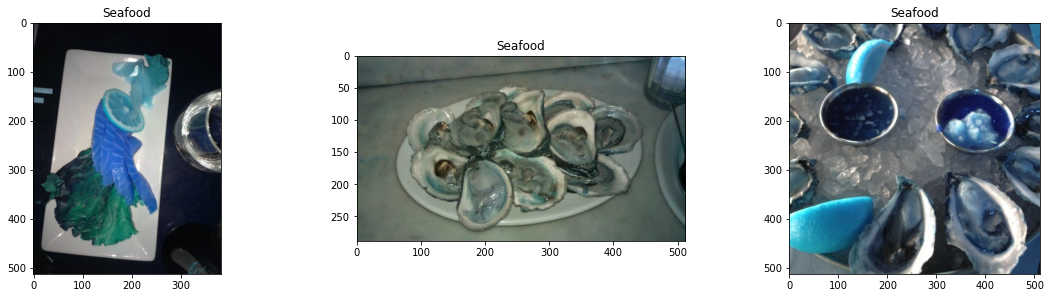

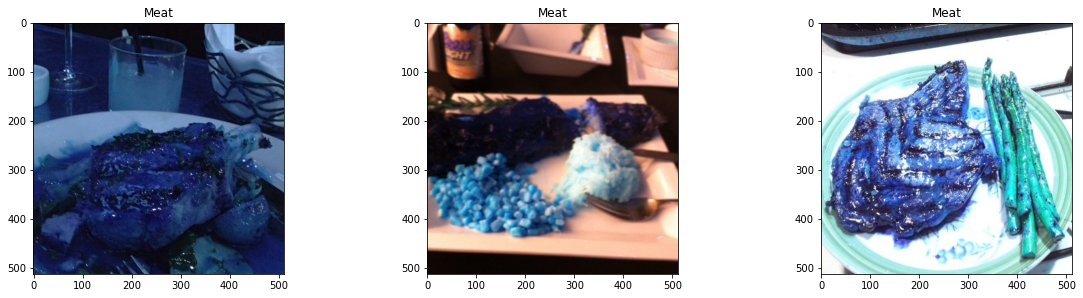

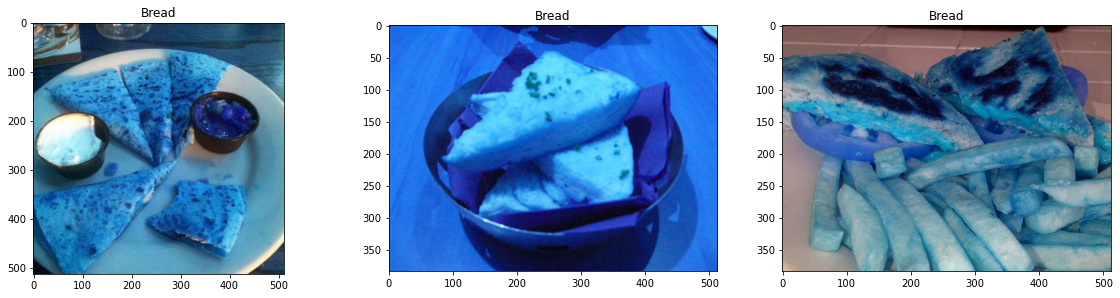

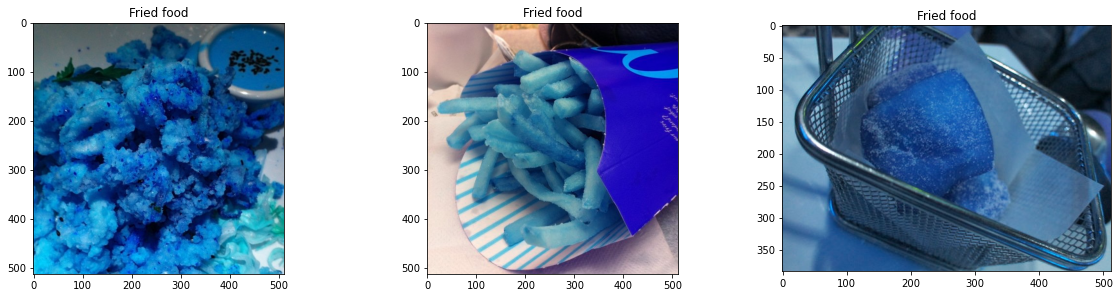

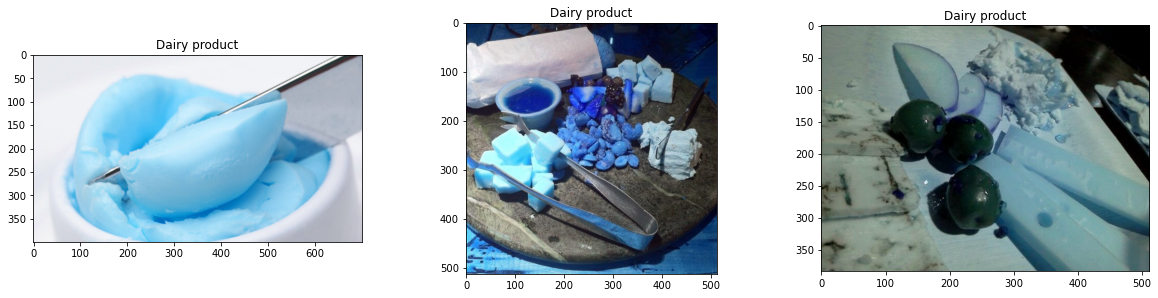

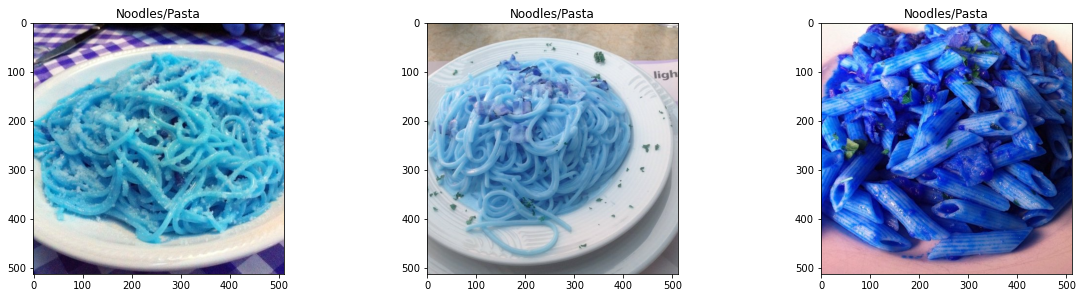

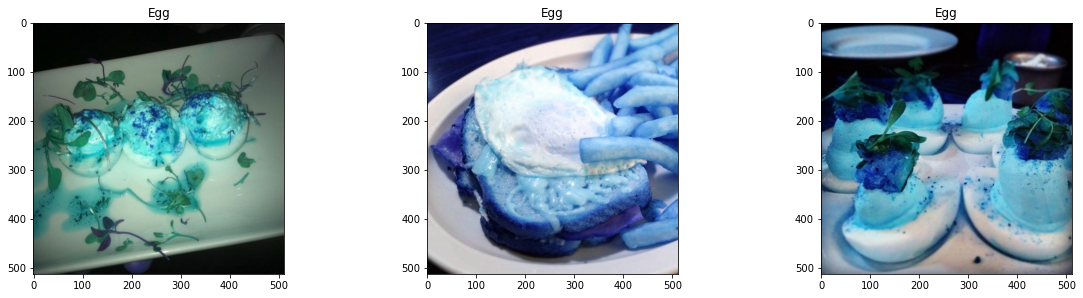

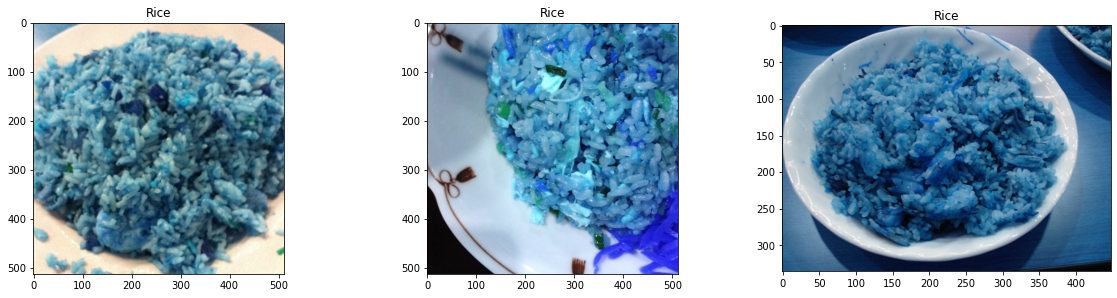

In [7]:
for food_class in df_paths_training['class'].unique():
    
    food = classes.get(int(food_class))  
    fig = plt.figure(figsize=(20, 60))
    # setting values to rows and column variables
    rows = 11
    columns = 3
    
    for i in range(0,3):
        
        df_slice = df_paths_training.loc[df_paths_training['class']==str(food_class),'path'].tolist()
    
        image = cv2.imread(training_dir+'/' +random.choice(df_slice))
        # displaying image
        fig.add_subplot(rows, columns, i+1)
        plt.title(food)
        plt.imshow(image)

## Question 5

### Generating images and labels 

In [8]:
#function to generate image data and labels for all subsets
def generate_data_labels(directory,df_path,img_height=50,img_width=50):

    image_data = []
    image_labels = []

    for index,row in df_path.iterrows():
        
        resizedimage = load_img(directory+'/'+row['path'],target_size=(img_height, img_width))
        image_data.append(img_to_array(resizedimage, dtype=int))
        image_labels.append(row['class'])
        
    return image_data,image_labels

In [9]:
#generating image data and labels for all subsets
training_image_data, training_image_labels = generate_data_labels(training_dir,df_paths_training)  
validation_image_data, validation_image_labels = generate_data_labels(validation_dir,df_paths_validation)
evaluation_image_data, evaluation_image_labels = generate_data_labels(test_dir,df_paths_evaluation)

In [10]:
training_image_data = np.array(training_image_data)
training_image_labels = np.array(training_image_labels)
print(training_image_data.shape, training_image_labels.shape)

print('---')

validation_image_data = np.array(validation_image_data)
validation_image_labels = np.array(validation_image_labels)
print(validation_image_data.shape, validation_image_labels.shape)

print('---')

evaluation_image_data = np.array(evaluation_image_data)
evaluation_image_labels = np.array(evaluation_image_labels)
print(evaluation_image_data.shape, evaluation_image_labels.shape)

(9866, 50, 50, 3) (9866,)
---
(3430, 50, 50, 3) (3430,)
---
(3347, 50, 50, 3) (3347,)


### Shuffling & normalizing data

In [11]:
#shuffling data for all subsets
for image_data, image_labels in [(training_image_data,training_image_labels),(validation_image_data,validation_image_labels),
                    (evaluation_image_data,evaluation_image_labels)] :
    
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    image_data = image_data[shuffle_indexes]
    image_labels = image_labels[shuffle_indexes]

In [12]:
#normalizing image data
X_train = training_image_data/255
X_val = validation_image_data/255
Y_train = training_image_labels
Y_val = validation_image_labels

### One hot encoding Y sets

In [13]:
Y_train = keras.utils.to_categorical(Y_train, num_categories)
Y_val = keras.utils.to_categorical(Y_val, num_categories)

### Data augmentation

## Question 6

### VGG16 model

In [77]:
#loading base model
base_model = VGG16(input_shape = (50, 50, 3), include_top = False, weights = 'imagenet')

#disabling training forlayers in base model
for layer in base_model.layers:
    layer.trainable = False

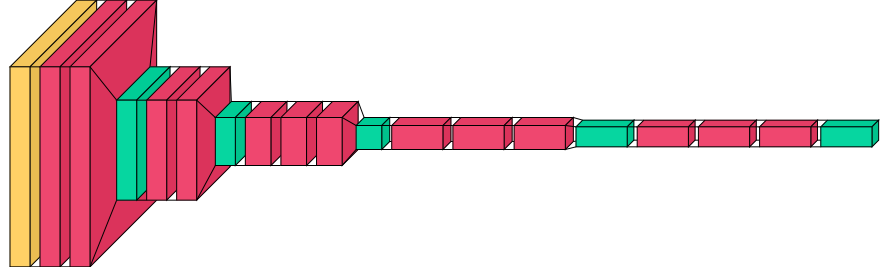

In [65]:
visualkeras.layered_view(base_model)

In [71]:
from keras.layers import Input, Flatten, Dense

#Create your own input format (here 3x200x200)
input = Input(shape=(50,50,3),name = 'image_input')

#Use the generated model 
base_model_output = base_model(input)

The following Variables were used a Lambda layer's call (tf.nn.convolution_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_13), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_14), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this

The following Variables were used a Lambda layer's call (tf.nn.convolution_23), but
are not present in its tracked objects:
  <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_23), but
are not present in its tracked objects:
  <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_24), but
are not present in its tracked objects:
  <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32>
It is possible tha

In [55]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [83]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a final softmax layer with 43 units for classification
x = layers.Dense(num_categories, activation='softmax')(x)

# Build final model with VGG base and x model which is the tail
model = tf.keras.models.Model(base_model.input, x)

# Compiling the model 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

vgg_hist = model.fit(aug.flow(X_train, Y_train, batch_size=32),epochs=epochs, validation_data=(X_val, Y_val))